<left>FINM 33150 - Quantitative Trading Strategies</left>
<left>Winter 2023</left>
<br>
<h1><center> Homework 1: Futures Spread Dynamics </center></h1>
<center>Due - 23:00 [CST] January 12th, 2023</center>
<br>
<h3>Ki Hyun</h3>
<h3>Student ID: 12125881</h3>

<h2> 1. Imports and Functions </h2>

<h5> Imports </h5>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
from datetime import datetime, timedelta

<h5> Constants </h5>

In [2]:
# API Key
PersonalApiKey = "JbMPn9bSpFPNS7Z7PcZy"
# Pairs
pairs1 = {"W": ['OWF/NYM_RB_RB', 1.0], "X": ['OWF/ICE_G_G', 0.0033]}
pairs2 = {"Y": ['OWF/ICE_B_B', 1.0], "Z": ['OWF/ICE_G_G', 0.1147]}
# start and stop dates
start_date = "2020-12-03"
end_date = "2022-08-31"

In [3]:
# possible quarters
class quarters:
    def __init__(self, start_date):
        self.quarters = ['H', 'M', 'U', 'Z']
        self.year = int(start_date.split("-")[0])
        month = int(start_date.split("-")[1])
        if month < 3:
            self.index = 0
        elif month < 6:
            self.index = 1
        elif month < 9:
            self.index = 2
        elif month < 12:
            self.index = 3
        else:
            self.year += 1
            self.index = 0

        self.label = "_" + self.quarters[self.index] + str(self.year) + "_IVM"

    def next(self):
        if self.index == 3:
            self.year += 1
            self.index = 0
        else:
            self.index += 1

        self.label = "_" + self.quarters[self.index] + str(self.year) + "_IVM"

<h5> Helper Functions </h5>
<h6> Collecting and Processing Data </h6>

In [4]:
"""
This code was given by Dr. Boonstra, B., Ph.D. for
University of Chicago FINM 33150 Quandl Options Data Fetching guidelines
"""
@functools.lru_cache(maxsize=1600)
def fetch_quandl(my_data_items, trim_start=None, trim_end=None):
    qdata = quandl.get(list(my_data_items), returns="pandas",
                      trim_start=trim_start, trim_end=trim_end,
                      api_key=PersonalApiKey)
    return qdata

In [5]:
"""
This code was given by Dr. Boonstra, B., Ph.D. for
University of Chicago FINM 33150 Quandl Options Data Fetching guidelines
and was modified for futures contract analysis
"""
def clean_quandl_future_columns(dataframe, pair):
    replacement_columns = {}
    for c in dataframe.columns:
        series_name, variable = c.split(' - ')
        source_name, asset = series_name.split('/')
        replacement_columns[c] = pair + "_" + variable
    renamed_data = dataframe.rename(columns=replacement_columns)
    return renamed_data[[pair + "_" + 'Future', pair + "_" + 'DtT']]

In [6]:
def fetch_second_month_futures(contract_label, pair, start_date, end_date):
    data= clean_quandl_future_columns(fetch_quandl((contract_label,),
                                                   start_date, end_date),
                                      pair)

    return data[data[pair + "_" + 'DtT'] > 30][pair + "_" + 'Future']
    #only returning future prices that expires in more than 30 days

In [7]:
def compile_data(pairs, start_date, end_date):
    ret_list = []
    for pair, detail in pairs.items():
        df = pd.DataFrame(dtype = float)
        start = start_date
        heading = detail[0]
        multiplier = detail[1]
        tail = quarters(start_date)
        while(start < end_date):
            temp = fetch_second_month_futures(heading + tail.label, pair, start, end_date)
            df = pd.concat([df, temp])
            start = (temp.index[-1] + timedelta(days = 1)).strftime("%Y-%m-%d")
            tail.next()
        #print(tail.label) # checking for up to which quarter
        df = df.rename(columns = {0:pair + '_Future'})
        df[pair + '_Future'] *= multiplier
        ret_list.append(df)
    return pd.concat(ret_list, axis = 1, join = 'inner')

<h6> Analysis Functions </h6>

In [8]:
def summary_statistics(df):
    data_frame = df.copy()
    data_frame = data_frame.dropna()
    summary_stats = data_frame.mean().to_frame('Mean')
    summary_stats['Median'] = data_frame.median().round(6)
    summary_stats['Volatility'] = data_frame.std().round(6)
    summary_stats['Q1'] = data_frame.quantile(0.25).round(6)
    summary_stats['Q3'] = data_frame.quantile(0.75).round(6)
    summary_stats['IQR'] = (summary_stats['Q3'] - summary_stats['Q1']).round(6)
    summary_stats['Min'] = data_frame.min()
    summary_stats['Max'] = data_frame.max()
    summary_stats['Skewness'] = data_frame.skew().round(6)

    return summary_stats

In [9]:
def abhline(y_intercept, line_style, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = np.repeat(y_intercept, len(x_vals))
    plt.plot(x_vals, y_vals, line_style, color = color)

In [10]:
def abvline(x_intercept, line_style, color):
    axes = plt.gca()
    y_vals = np.array(axes.get_ylim())
    x_vals = np.repeat(x_intercept, len(y_vals))
    plt.plot(x_vals, y_vals, line_style, color = color)

<h2> 2. Data </h2>

<h3> 2-1. Raw Data </h3>

The raw data for this analysis was obtained from <a href = "https://data.nasdaq
.com/data/OWF-optionworks-futures-options/documentation?anchor=publisher">
"Nasdaq Data Link (Quandl) OptionWorks Futures Option (OWF)" </a> data feed.

All available data, ranging from December 3rd 2020 through August 31st 2022, regarding second month quarterly future
prices on Gasoline (New York Mercantile Exchange), ICE Gas Oil (Intercontinental Exchange), and Brent Crude Oil
(Intercontinental Exchange) were collected from Quandl OWF database.

As a result, data on futures contracts expiring in the first quarter of 2021 to the contracts expiring in the last
quarter of 2022 were collected. The raw data contained 16 columns and date was set as the index.

<h3> 2-2. Data Processing </h3>

In [11]:
# getting future prices data for W, X pair
df_WX = compile_data(pairs1, start_date, end_date)
# computing the spread
df_WX[r'$Spread^{W, X}$'] = df_WX['X_Future'] - df_WX['W_Future']
# dropping other columns
df_WX = df_WX[[r'$Spread^{W, X}$']]

In [12]:
# getting future prices data for Y, Z pair
df_YZ = compile_data(pairs2, start_date, end_date)
# computing the spread
df_YZ[r'$Spread^{Y, Z}$'] = df_YZ['Z_Future'] - df_YZ['Y_Future']
# dropping other columns
df_YZ = df_YZ[[r'$Spread^{Y, Z}$']]

First, for each asset, 2 were used for data processing. The date to termination column was used to filter the contract
for each day that had the lowest time to expiration, but over 30 days. After filtering the data, the futures price
column was chosen for analysis.

The futures contract on three different assets were split into two pairs.
Gasoline and ICE Gas Oil were the first pair (pair W, X); Brent Crude Oil and ICE Gas oil were the second (pair Y, Z).

Prior to computing the weighted spread, some weights were multiplied to one of the futures prices for each pair.
For the W, X pair, 0.0033 was multiplied to the ICE Gas Oil futures price. For the Y, Z pair, 0.1147 was multiplied
to the ICE Gas Oil futures price.

Lastly, the weighted spreads for each W, X; Y, Z pair, $s^{(1)}$ and $s^{(2)}$ respectively, were computed as below:

- For W, X pair, for each day $t$, and weighted futures prices $X_t$ and $W_t$:
$$
s_t^{(1)} = X_t - W_t
$$
- For Y, Z pair, for each day $t$, and weighted futures prices $Y_t$ and $Z_t$:
$$
s_t^{(2)} = Z_t - Y_t
$$

<h3> 2-3. Data Description </h3>

The processed data for each pair had the weighted futures price spread as its sole column and date as the index.

The Gasoline and ICE Gas Oil pair (W, X pair) dataset includes 450 dates.
The Brent Crude Oil and ICE Gas Oil pair (Y, Z pair) dataset also has 450 dates.

The first five rows of the W, X pair dataset is shown below:

In [13]:
df_WX.head()

,"$Spread^{W, X}$"
2020-12-03,0.048975
2020-12-04,0.044700
2020-12-07,0.068000
2020-12-08,0.067075
2020-12-09,0.043975


The first five rows of the Y, Z pair dataset is shown below:

In [14]:
df_YZ.head()

,"$Spread^{Y, Z}$"
2020-12-03,-2.175175
2020-12-04,-2.621800
2020-12-07,-1.773000
2020-12-08,-1.811675
2020-12-09,-2.115775


<h2> 3. Analysis </h2>

<h3> 3-1. W, X Pair </h3>
<h4> <i> Summary Statistics </i> </h4>

In [15]:
summary_statistics(df_WX)

,Mean,Median,Volatility,Q1,Q3,IQR,Min,Max,Skewness
"$Spread^{W, X}$",0.010279,-0.024125,0.267353,-0.189831,0.058163,0.247994,-0.36415,1.036175,1.558228


Shown above is the summary statistics for the W, X pair's weighted spread.

The mean value of the weighted spread (0.010279) is greater than the median (-0.024125). Moreover, the skewness of the
weighted spread is greater than one. Therefore, the summary statistics shows that the weighted spread of the W, X pair
is positively and highly skewed.

The variation of the weighted spread was also high with volatility of approximately 0.267 and Inter Quantile Range of
0.247994

<h4> <i> Box Plot </i> </h4>

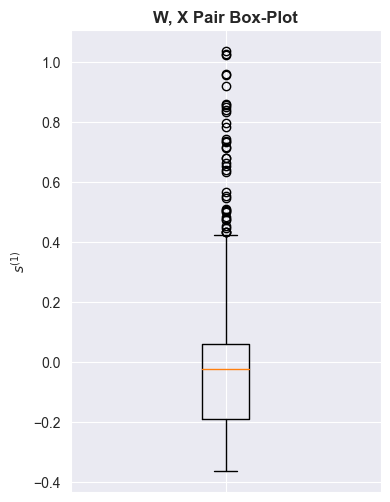

In [16]:
# set figure window
fig = plt.figure(figsize=(4,6))
# set axis
ax  = fig.add_subplot(111)
# boxplot
ax.boxplot(df_WX)
# x axis ticks and labels
ax.set_xlabel(None)
plt.xticks([1], [""])
# y axis labels
ax.set_ylabel(r'$s^{(1)}$', fontsize=10)
# title
ax.set_title('W, X Pair Box-Plot', fontsize=12, fontweight = "bold")
None

The box-plot above more clearly shows that the data is positively skewed and that there are a lot of outliers in the
data with values greater than 0.430154

<h4> <i> Time-series Plot </i> </h4>

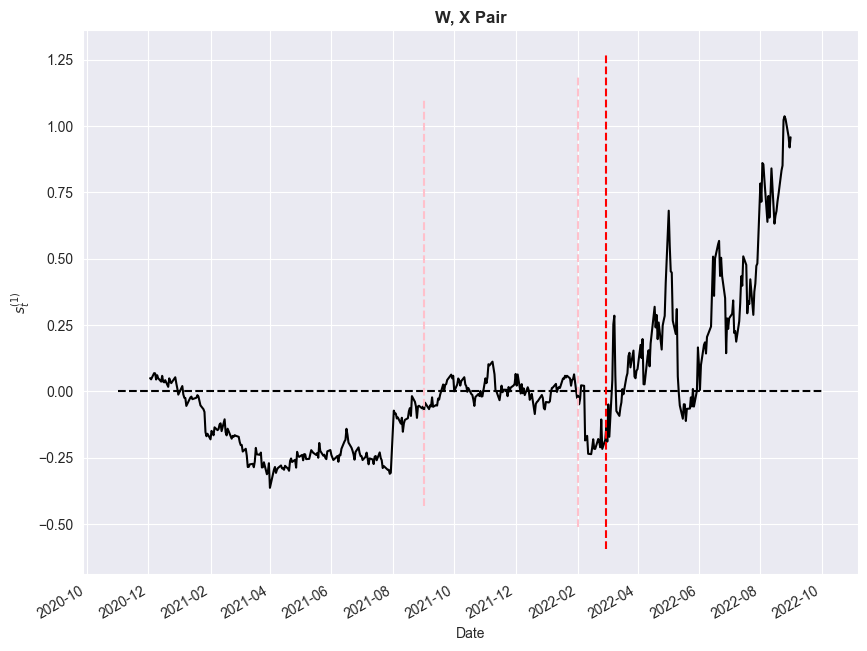

In [17]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(df_WX, color = "black")
# add annotative lines
abhline(0, '--', 'black')
abvline(datetime(2021, 9, 1), '--', 'pink')
abvline(datetime(2022, 2, 1), '--', 'pink')
abvline(datetime(2022, 3, 1), '--', 'red')
# x axis ticks and labels
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel(r'$s^{(1)}_t$', fontsize=10)
# title
ax.set_title('W, X Pair', fontsize=12, fontweight = "bold")
None

The time-series plot shows where most of the variation and skewness in the weighted futures spread for the W, X pair
comes from.

The plot shows that from December 2020 to September 2021, the weighted spreads between Gasoline and ICE Gas Oil futures
were mostly negative.

From September 2021 to February 2022, the weighted spreads were mostly steady--revolving around 0.

Apart from the sudden jump in spread around August 2021, the weighted spread's volatility is relatively low up till
February 2022.

However, after a sudden drop in February 2022, the weighted spread increases dramatically with a heavy increase
in volatility. Past March 2022, the weighted spread is mostly positive, yet fluctuates in much greater scale than
before.

<h4> <i> Moving Average </i> </h4>

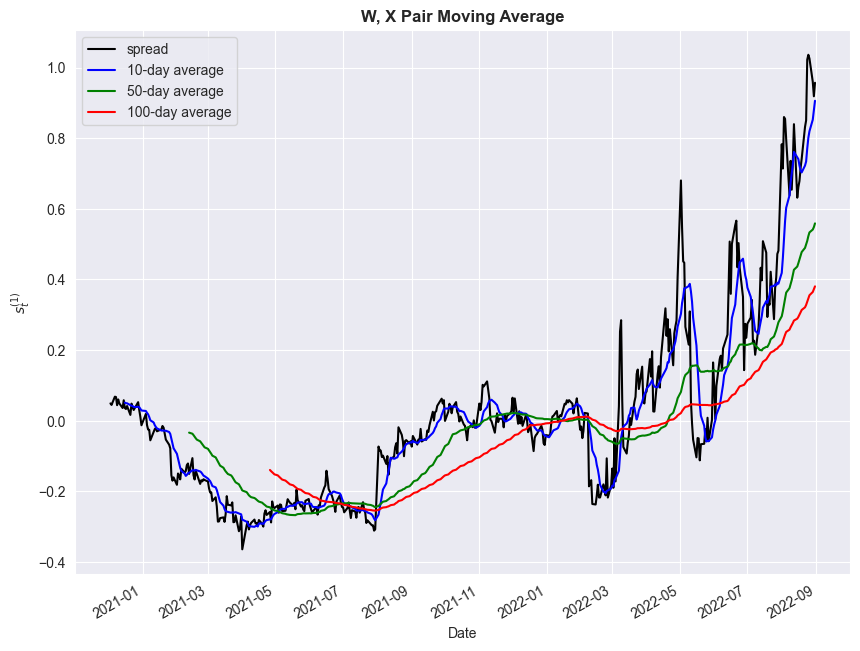

In [18]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(df_WX, color = "black", label = "spread")
ax.plot(df_WX.rolling(10).mean(), color = "blue", label = "10-day average")
ax.plot(df_WX.rolling(50).mean(), color = "green", label = "50-day average")
ax.plot(df_WX.rolling(100).mean(), color = "red", label = "100-day average")
# include legend
ax.legend(loc = "upper left")
# x axis labels
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel(r'$s^{(1)}_t$', fontsize=10)
# title
ax.set_title('W, X Pair Moving Average', fontsize=12, fontweight = "bold")
None

10-day, 50-day, and 100-day rolling average of the W, X weighted spreads were plotted to show the short-term and
long-term trends.

The 100-day average is mostly beneath the 50-day average, apart from May 2021 to July 2021 and January 2022 to
April 2022. The 10-day average tracks the fluctuations in the spread closely and, thus, crosses over the 50-day and
100-day average more often, following a sudden increase or decrease in the spread.

In [19]:
df_WX[r'$d_t^{(10)}$'] = df_WX[r'$Spread^{W, X}$'].rolling(10).mean() - df_WX[r'$Spread^{W, X}$']
df_WX[r'$d_t^{(50)}$'] = df_WX[r'$Spread^{W, X}$'].rolling(50).mean() - df_WX[r'$Spread^{W, X}$']
df_WX[r'$d_t^{(100)}$'] = df_WX[r'$Spread^{W, X}$'].rolling(100).mean() - df_WX[r'$Spread^{W, X}$']

<h5> <b> 10-day Rolling Average </b> </h5>

In [20]:
summary_statistics(df_WX[[r'$d_t^{(10)}$']])

,Mean,Median,Volatility,Q1,Q3,IQR,Min,Max,Skewness
$d_t^{(10)}$,-0.009232,-0.00096,0.084279,-0.03365,0.025267,0.058917,-0.37778,0.345147,-0.573989


The difference between $s_t^{(1)}$ and 10-day rolling average ($d_t^{(10)}$) is negatively skewed. Given that the
mean and median are both negative, the 10-day rolling average may be considered to be mostly lower than the weighted
spread. However, the volatility of the difference is relatively high compared to the mean value.

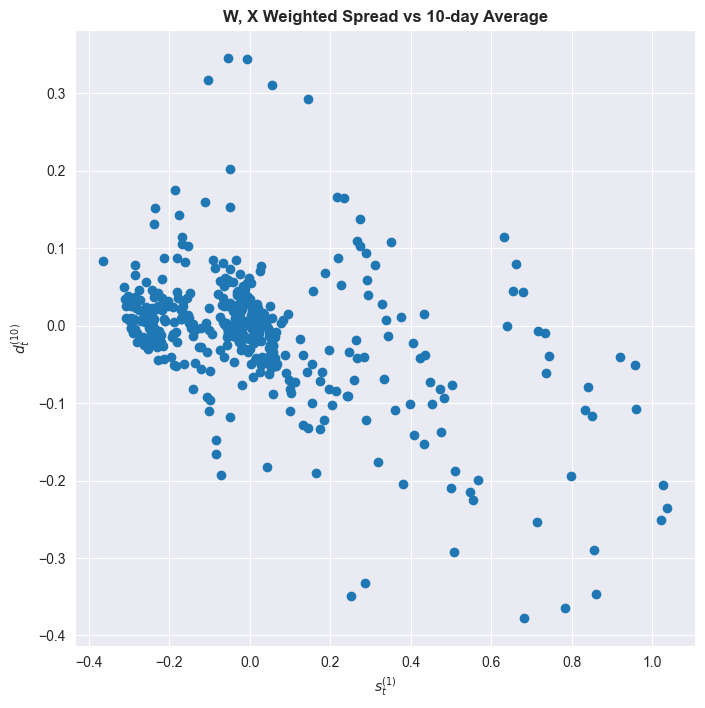

In [21]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_WX[r'$Spread^{W, X}$'], df_WX[r'$d_t^{(10)}$'])
# x axis labels
ax.set_xlabel(r'$s^{(1)}_t$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(10)}_t$', fontsize=10)
# title
ax.set_title('W, X Weighted Spread vs 10-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the W, X weighted spread and it's 10-day average does not show correlation.

<h5> <b> 50-day Rolling Average </b> </h5>

In [22]:
summary_statistics(df_WX[[r'$d_t^{(50)}$']])

,Mean,Median,Volatility,Q1,Q3,IQR,Min,Max,Skewness
$d_t^{(50)}$,-0.04668,-0.01949,0.145965,-0.120251,0.04206,0.162311,-0.5987,0.260614,-0.911649


The difference between $s_t^{(1)}$ and 50-day rolling average ($d_t^{(50)}$) is highly negatively skewed. Given that the
mean and median are both negative, the 50-day rolling average may be considered to be mostly lower than the weighted
spread. Moreover, the difference is greater in magnitude compared to the difference for the 10-day rolling average.
However, similar to the 10-day average, the volatility of the difference is relatively high compared to the mean value.

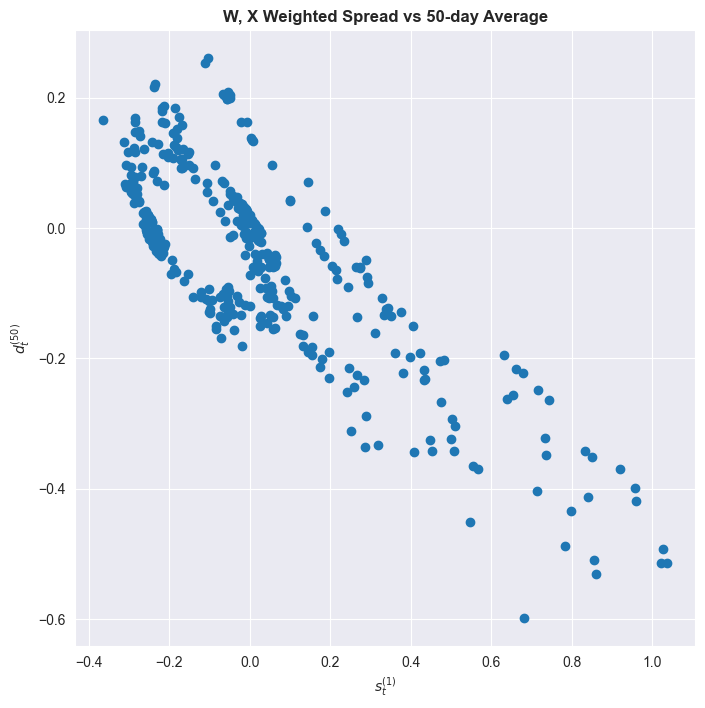

In [23]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_WX[r'$Spread^{W, X}$'], df_WX[r'$d_t^{(50)}$'])
# x axis labels
ax.set_xlabel(r'$s^{(1)}_t$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(50)}_t$', fontsize=10)
# title
ax.set_title('W, X Weighted Spread vs 50-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the W, X weighted spread and it's 50-day average shows a semi-strong negative correlation.

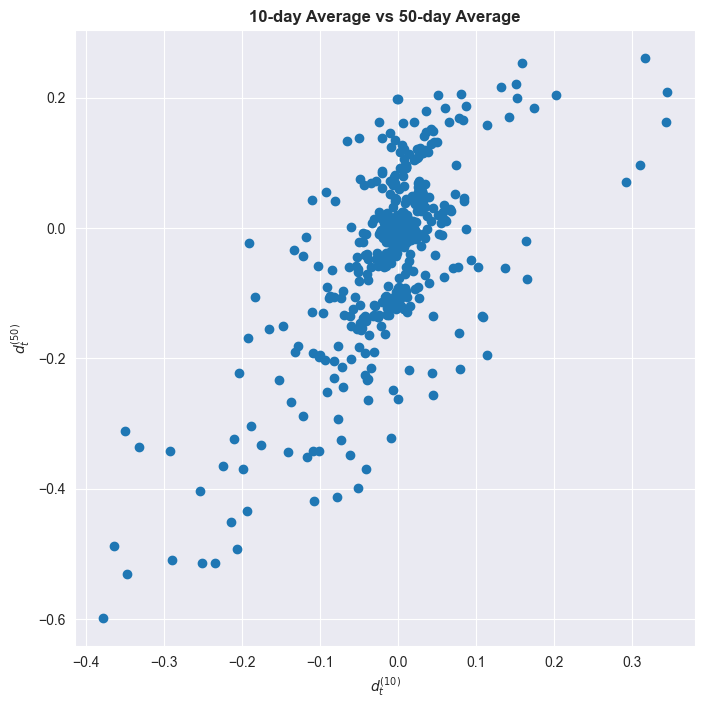

In [24]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_WX[r'$d_t^{(10)}$'], df_WX[r'$d_t^{(50)}$'])
# x axis labels
ax.set_xlabel(r'$d_t^{(10)}$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(50)}_t$', fontsize=10)
# title
ax.set_title('10-day Average vs 50-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the W, X weighted spread's 10-day and 50-day average shows a weak positive correlation.

<h5> <b> 100-day Rolling Average </b> </h5>

In [25]:
summary_statistics(df_WX[[r'$d_t^{(100)}$']])

,Mean,Median,Volatility,Q1,Q3,IQR,Min,Max,Skewness
$d_t^{(100)}$,-0.100528,-0.076667,0.174621,-0.172881,0.022063,0.194944,-0.690997,0.238934,-1.007612


The difference between $s_t^{(1)}$ and 100-day rolling average ($d_t^{(100)}$) is highly negatively skewed. Given that
the mean and median are both negative, the 100-day rolling average may be considered to be mostly lower than the
weighted spread. Moreover, the difference is greater in magnitude compared to the two previous differences measured.
Again, as expected, the volatility of $d_t^{(100)}$ is the highest, yet not much higher than that of $d_t^{(50)}$.

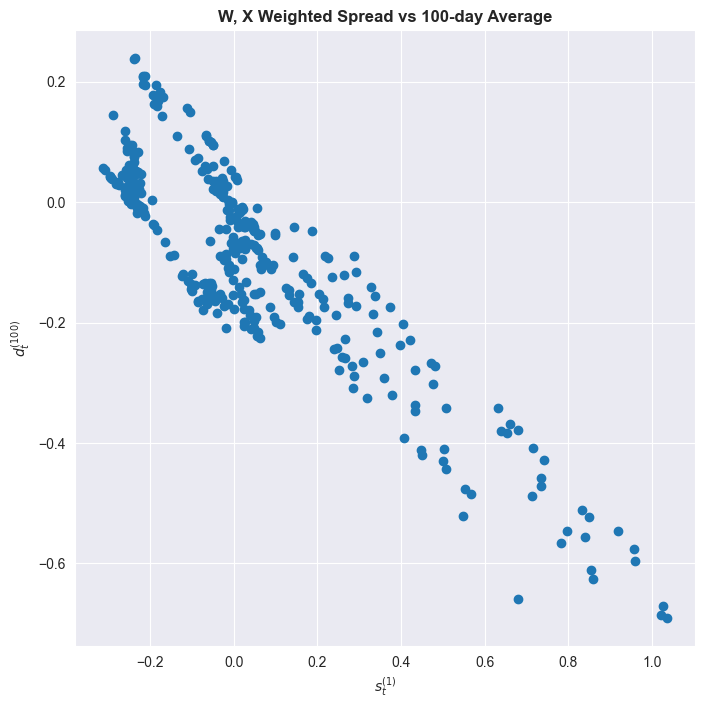

In [26]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_WX[r'$Spread^{W, X}$'], df_WX[r'$d_t^{(100)}$'])
# x axis labels
ax.set_xlabel(r'$s^{(1)}_t$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(100)}_t$', fontsize=10)
# title
ax.set_title('W, X Weighted Spread vs 100-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the W, X weighted spread and it's 100-day average shows a strong negative correlation.

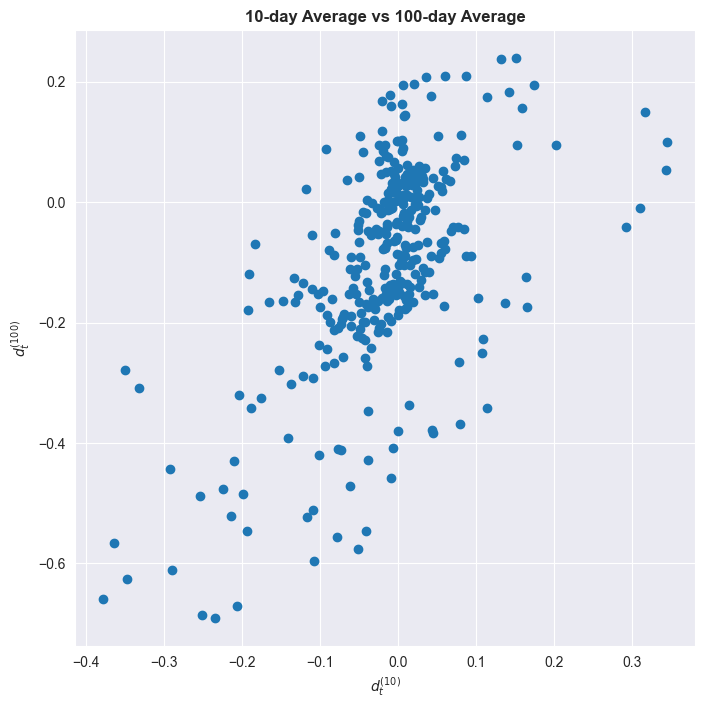

In [27]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_WX[r'$d_t^{(10)}$'], df_WX[r'$d_t^{(100)}$'])
# x axis labels
ax.set_xlabel(r'$d_t^{(10)}$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(100)}_t$', fontsize=10)
# title
ax.set_title('10-day Average vs 100-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the W, X weighted spread's 10-day and 100-day average shows a weak positive correlation.

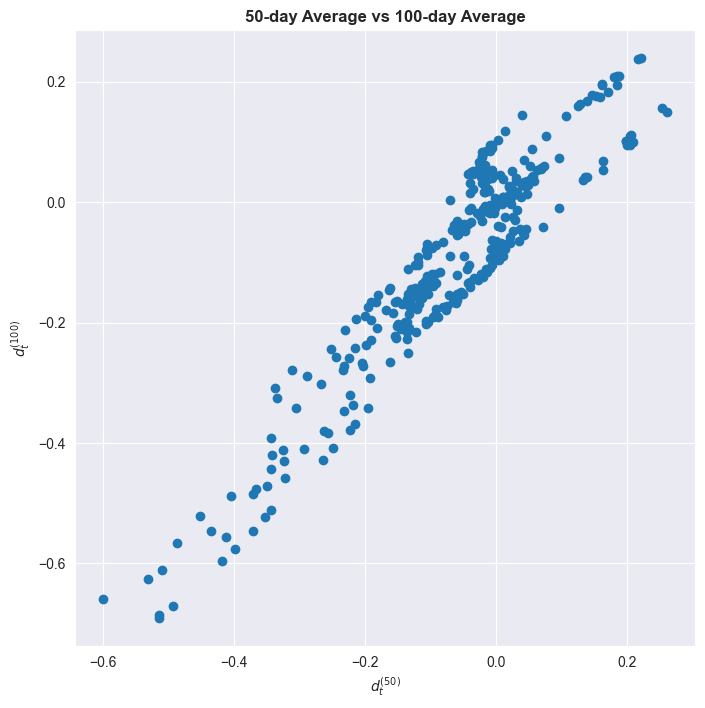

In [28]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_WX[r'$d_t^{(50)}$'], df_WX[r'$d_t^{(100)}$'])
# x axis labels
ax.set_xlabel(r'$d_t^{(50)}$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(100)}_t$', fontsize=10)
# title
ax.set_title('50-day Average vs 100-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the W, X weighted spread's 50-day and 100-day average shows a strong positive correlation.

<h5> <b> Overall Correlation </b> </h5>

In [29]:
df_WX.corr()

,"$Spread^{W, X}$",$d_t^{(10)}$,$d_t^{(50)}$,$d_t^{(100)}$
"$Spread^{W, X}$",1.000000,-0.459054,-0.811221,-0.889978
$d_t^{(10)}$,-0.459054,1.000000,0.691766,0.600405
$d_t^{(50)}$,-0.811221,0.691766,1.000000,0.941152
$d_t^{(100)}$,-0.889978,0.600405,0.941152,1.000000


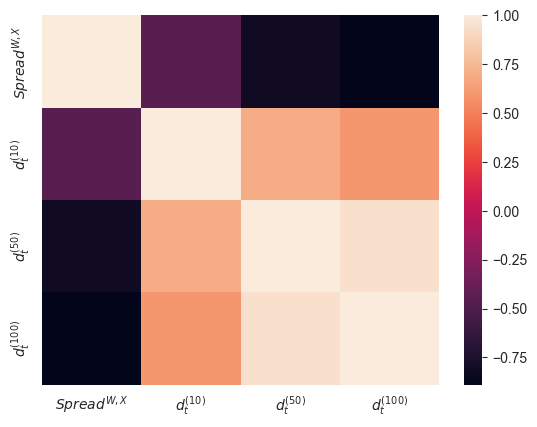

In [30]:
sns.heatmap(df_WX.corr())
None

<h3> 3-2. Y, Z Pair </h3>
<h4> <i> Summary Statistics </i> </h4>

In [31]:
summary_statistics(df_YZ)

,Mean,Median,Volatility,Q1,Q3,IQR,Min,Max,Skewness
"$Spread^{Y, Z}$",3.453234,-1.8519,10.396729,-3.218875,5.328762,8.547637,-6.509025,32.6711,1.384908


Shown above is the summary statistics for the Y, Z pair's weighted spread.

The mean value of the weighted spread (3.453234) is greater than the median (-1.8573). Moreover, the skewness of the
weighted spread is greater than one (1.384908). Therefore, the summary statistics shows that the weighted spread of the
Y, Z pair is positively and highly skewed.

The variation of the weighted spread was also high with volatility of approximately 10.396729 and Inter Quantile
Range of 8.547637

Compared to the W, X pair, the Y, Z pair's weighted spread seems to be more heavily skewed in the same direction and
involves more variation

<h4> <i> Box Plot </i> </h4>

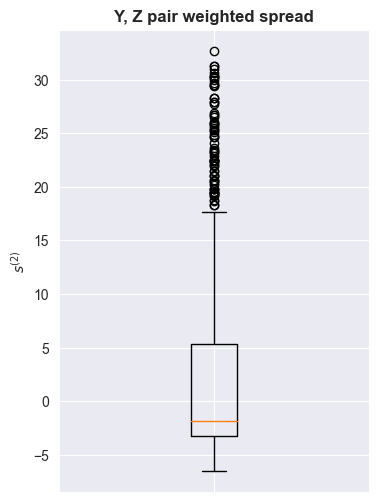

In [32]:
# set figure window
fig = plt.figure(figsize=(4,6))
# set axis
ax  = fig.add_subplot(111)
# boxplot
ax.boxplot(df_YZ)
# x axis ticks and labels
ax.set_xlabel(None)
plt.xticks([1], [""])
# y axis labels
ax.set_ylabel(r'$s^{(2)}$', fontsize=10)
# title
ax.set_title('Y, Z pair weighted spread', fontsize=12, fontweight = "bold")
None

The box-plot above more clearly shows that the data is positively skewed and that there are a lot of outliers in the
data with values greater than 18.150218

<h4> <i> Time-series Plot </i> </h4>

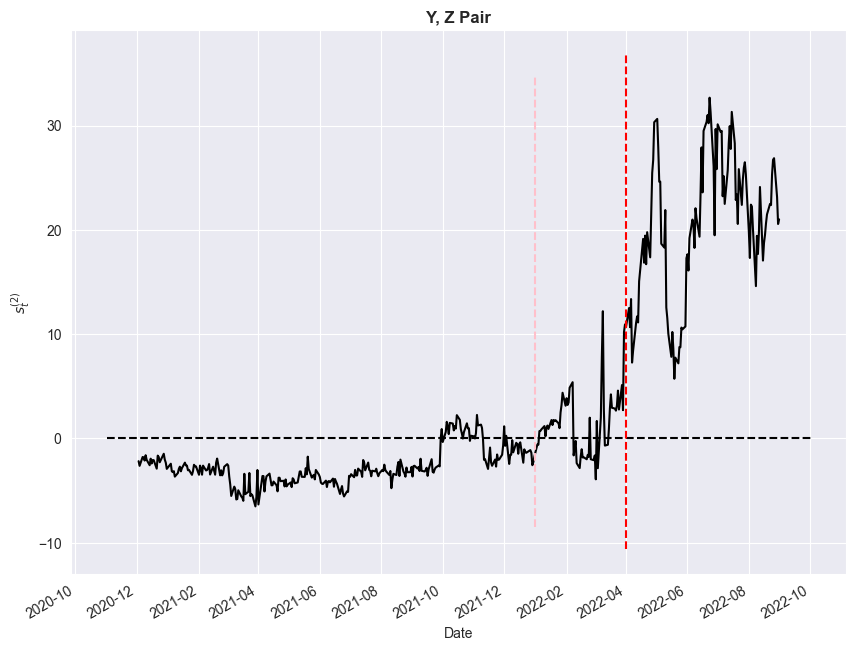

In [33]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(df_YZ, color = "black")
# add annotative lines
abhline(0, '--', 'black')
abvline(datetime(2022, 1, 1), '--', 'pink')
abvline(datetime(2022, 4, 1), '--', 'red')
# x axis ticks and labels
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel(r'$s^{(2)}_t$', fontsize=10)
# title
ax.set_title('Y, Z Pair', fontsize=12, fontweight = "bold")
None

The time-series plot shows where most of the variation and skewness in the weighted futures spread for the Y, Z pair
comes from.

The plot shows that from December 2020 to October 2021, the weighted spreads between Brent Crude Oil and ICE Gas Oil
futures were mostly negative.

From October 2021 to January 2022, the weighted spreads were mostly steady--revolving around 0.

However, the weighted spread increases, accompanied by a heavy increase in volatility. Past April 2022, the weighted
spread increases more drastically with higher volatility.

<h4> <i> Moving Average </i> </h4>

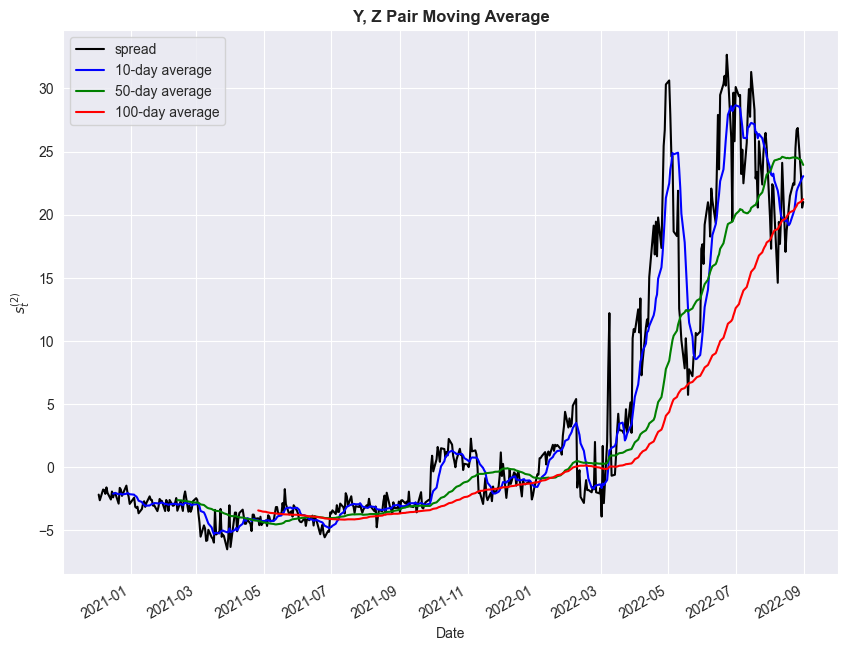

In [34]:
# set figure window
fig = plt.figure(figsize=(10,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.plot(df_YZ, color = "black", label = "spread")
ax.plot(df_YZ.rolling(10).mean(), color = "blue", label = "10-day average")
ax.plot(df_YZ.rolling(50).mean(), color = "green", label = "50-day average")
ax.plot(df_YZ.rolling(100).mean(), color = "red", label = "100-day average")
# include legend
ax.legend(loc = "upper left")
# x axis labels
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
# y axis labels
ax.set_ylabel(r'$s^{(2)}_t$', fontsize=10)
# title
ax.set_title('Y, Z Pair Moving Average', fontsize=12, fontweight = "bold")
None

10-day, 50-day, and 100-day rolling average of the Y, Z weighted spreads were plotted to show the short-term and
long-term trends. The 100-day average is mostly beneath the 50-day average, apart from May 2021 to July 2021. The
10-day average tracks the fluctuations in the spread closely and, thus, crosses over  the 50-day and 100-day average
more often, following a sudden increase or decrease in the spread.

In [35]:
df_YZ[r'$d_t^{(10)}$'] = df_YZ[r'$Spread^{Y, Z}$'].rolling(10).mean() - df_YZ[r'$Spread^{Y, Z}$']
df_YZ[r'$d_t^{(50)}$'] = df_YZ[r'$Spread^{Y, Z}$'].rolling(50).mean() - df_YZ[r'$Spread^{Y, Z}$']
df_YZ[r'$d_t^{(100)}$'] = df_YZ[r'$Spread^{Y, Z}$'].rolling(100).mean() - df_YZ[r'$Spread^{Y, Z}$']

<h5> <b> 10-day Rolling Average </b> </h5>

In [36]:
summary_statistics(df_YZ[[r'$d_t^{(10)}$']])

,Mean,Median,Volatility,Q1,Q3,IQR,Min,Max,Skewness
$d_t^{(10)}$,-0.257911,-0.047848,2.537476,-0.934352,0.503287,1.437639,-10.880078,11.061935,0.054621


The difference between $s_t^{(2)}$ and 10-day rolling average ($d_t^{(10)}$) is weakly positively skewed. Given that the
mean and median are both negative, the positive extreme values must be very high.

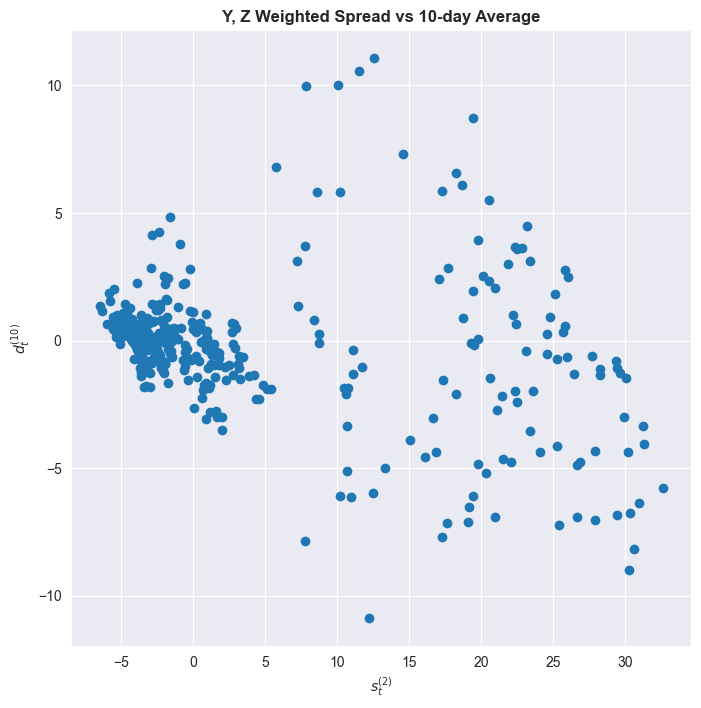

In [37]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_YZ[r'$Spread^{Y, Z}$'], df_YZ[r'$d_t^{(10)}$'])
# x axis labels
ax.set_xlabel(r'$s^{(2)}_t$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(10)}_t$', fontsize=10)
# title
ax.set_title('Y, Z Weighted Spread vs 10-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the Y, Z weighted spread and it's 10-day average does not show correlation.

<h5> <b> 50-day Rolling Average </b> </h5>

In [38]:
summary_statistics(df_YZ[[r'$d_t^{(50)}$']])

,Mean,Median,Volatility,Q1,Q3,IQR,Min,Max,Skewness
$d_t^{(50)}$,-1.548167,-0.418682,4.492463,-2.448882,0.817635,3.266517,-22.542799,9.766383,-1.759379


The difference between $s_t^{(2)}$ and 50-day rolling average ($d_t^{(50)}$) is highly negatively skewed. Given that the
mean and median are both negative, the 50-day rolling average may be considered to be mostly lower than the weighted
spread. The abundance of positive shocks in the weighted spread explains why the 50-day average is much lower than
the spread value more often and greater in magnitude.

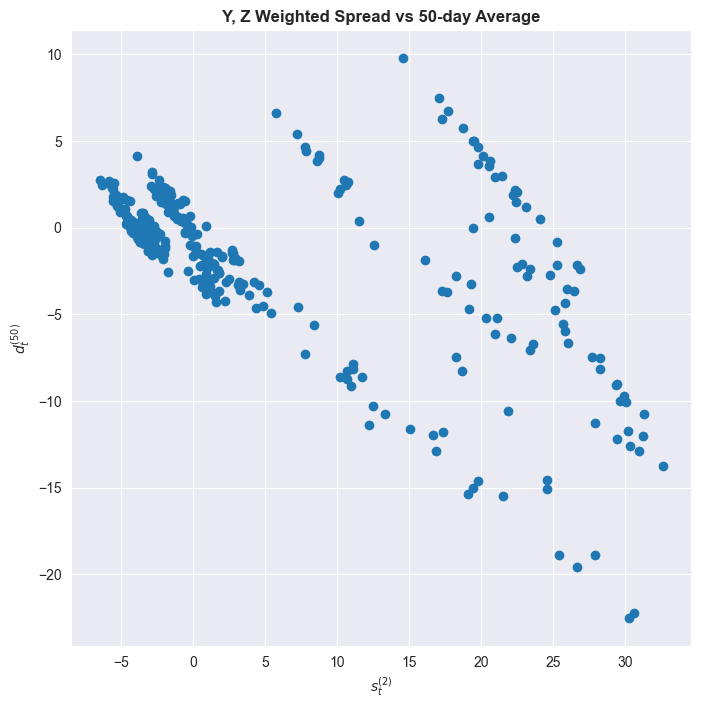

In [39]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_YZ[r'$Spread^{Y, Z}$'], df_YZ[r'$d_t^{(50)}$'])
# x axis labels
ax.set_xlabel(r'$s^{(2)}_t$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(50)}_t$', fontsize=10)
# title
ax.set_title('Y, Z Weighted Spread vs 50-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the Y, Z weighted spread and it's 50-day average shows a weak negative correlation.

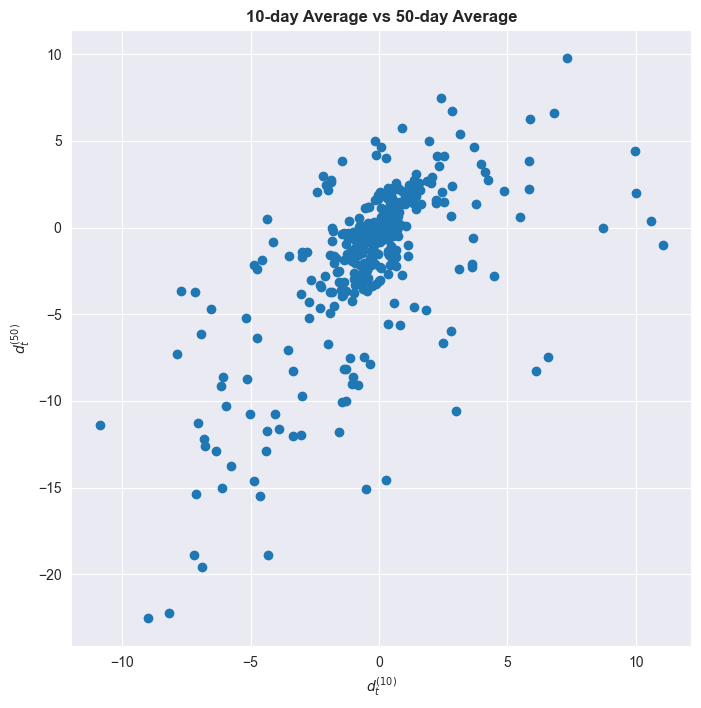

In [40]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_YZ[r'$d_t^{(10)}$'], df_YZ[r'$d_t^{(50)}$'])
# x axis labels
ax.set_xlabel(r'$d_t^{(10)}$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(50)}_t$', fontsize=10)
# title
ax.set_title('10-day Average vs 50-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the Y, Z weighted spread's 10-day and 50-day average shows a weak positive correlation.

<h5> <b> 100-day Rolling Average </b> </h5>

In [41]:
summary_statistics(df_YZ[[r'$d_t^{(100)}$']])

,Mean,Median,Volatility,Q1,Q3,IQR,Min,Max,Skewness
$d_t^{(100)}$,-3.718108,-1.423941,5.838259,-4.527444,-0.042394,4.48505,-26.259139,4.257009,-1.686404


The difference between $s_t^{(2)}$ and 100-day rolling average ($d_t^{(100)}$) is highly negatively skewed. Given that
the mean and median are both negative, the 100-day rolling average may also be considered to be mostly lower than the
weighted spread. Though the volatility is greater than the 50-day average's difference, the skewness is less.

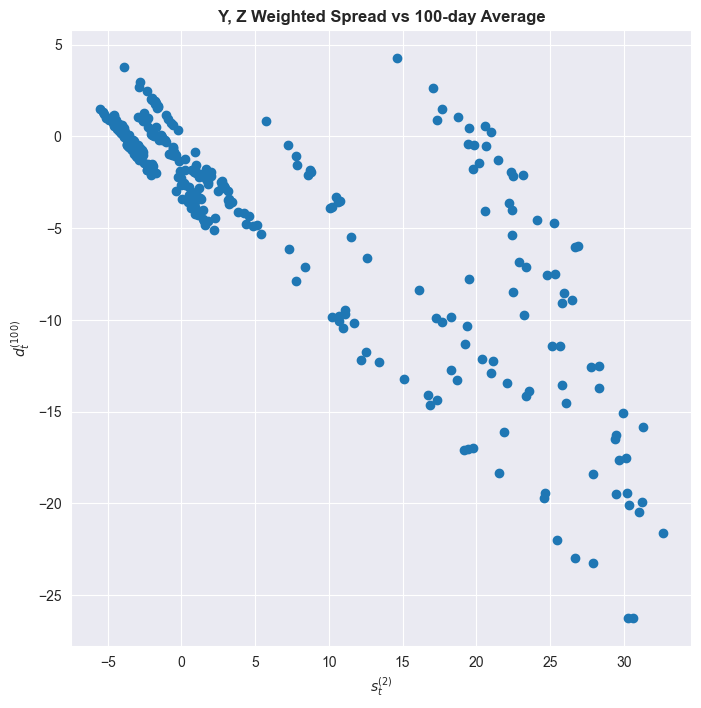

In [42]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_YZ[r'$Spread^{Y, Z}$'], df_YZ[r'$d_t^{(100)}$'])
# x axis labels
ax.set_xlabel(r'$s^{(2)}_t$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(100)}_t$', fontsize=10)
# title
ax.set_title('Y, Z Weighted Spread vs 100-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the Y, Z weighted spread and it's 100-day average shows a semi-strong negative correlation.

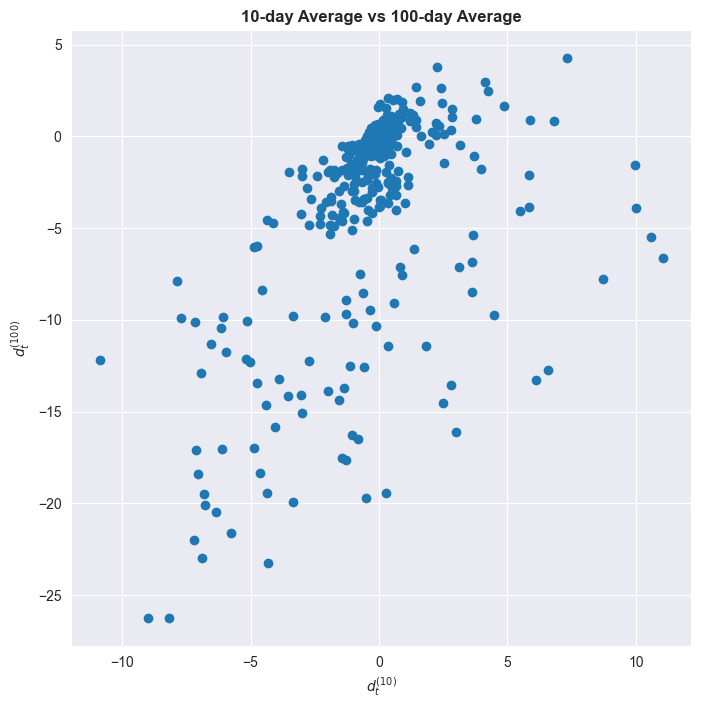

In [43]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_YZ[r'$d_t^{(10)}$'], df_YZ[r'$d_t^{(100)}$'])
# x axis labels
ax.set_xlabel(r'$d_t^{(10)}$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(100)}_t$', fontsize=10)
# title
ax.set_title('10-day Average vs 100-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the Y, Z weighted spread's 10-day and 100-day average shows a very weak positive correlation.

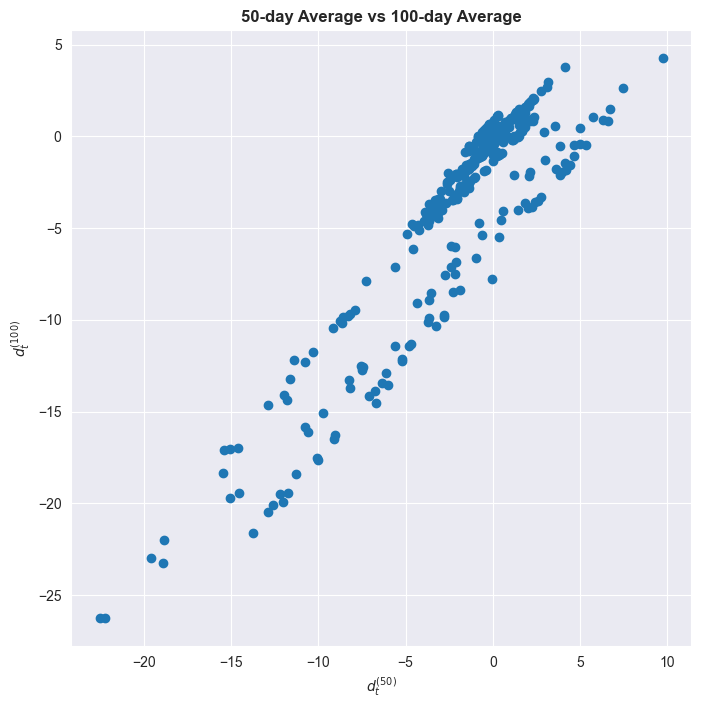

In [44]:
# set figure window
fig = plt.figure(figsize=(8,8))
# set axis
ax  = fig.add_subplot(111)
# time-series plot
ax.scatter(df_YZ[r'$d_t^{(50)}$'], df_YZ[r'$d_t^{(100)}$'])
# x axis labels
ax.set_xlabel(r'$d_t^{(50)}$', fontsize=10)
# y axis labels
ax.set_ylabel(r'$d^{(100)}_t$', fontsize=10)
# title
ax.set_title('50-day Average vs 100-day Average', fontsize=12, fontweight = "bold")
None

The scatter plot of the Y, Z weighted spread's 50-day and 100-day average shows a strong positive correlation.

<h5> <b> Overall Correlation </b> </h5>

In [45]:
df_YZ.corr()

,"$Spread^{Y, Z}$",$d_t^{(10)}$,$d_t^{(50)}$,$d_t^{(100)}$
"$Spread^{Y, Z}$",1.000000,-0.270550,-0.573523,-0.805717
$d_t^{(10)}$,-0.270550,1.000000,0.622148,0.505704
$d_t^{(50)}$,-0.573523,0.622148,1.000000,0.916451
$d_t^{(100)}$,-0.805717,0.505704,0.916451,1.000000


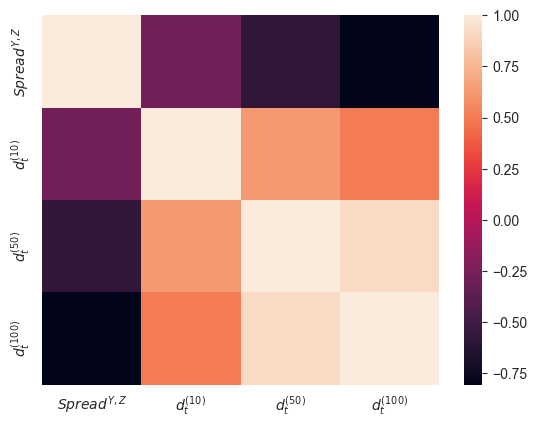

In [46]:
sns.heatmap(df_YZ.corr())
None

<h3> 3-3. W, X; Y, Z Correlation </h3>

In [47]:
pd.concat([df_WX, df_YZ], axis = 1, join = 'inner').corr()

,"$Spread^{W, X}$",$d_t^{(10)}$,$d_t^{(50)}$,$d_t^{(100)}$,"$Spread^{Y, Z}$",$d_t^{(10)}$,$d_t^{(50)}$,$d_t^{(100)}$
"$Spread^{W, X}$",1.000000,-0.459054,-0.811221,-0.889978,0.841189,-0.224549,-0.329279,-0.509501
$d_t^{(10)}$,-0.459054,1.000000,0.691766,0.600405,-0.320430,0.676334,0.348005,0.304257
$d_t^{(50)}$,-0.811221,0.691766,1.000000,0.941152,-0.618447,0.427458,0.481730,0.479820
$d_t^{(100)}$,-0.889978,0.600405,0.941152,1.000000,-0.667579,0.345539,0.372917,0.500847
"$Spread^{Y, Z}$",0.841189,-0.320430,-0.618447,-0.667579,1.000000,-0.270550,-0.573523,-0.805717
$d_t^{(10)}$,-0.224549,0.676334,0.427458,0.345539,-0.270550,1.000000,0.622148,0.505704
$d_t^{(50)}$,-0.329279,0.348005,0.481730,0.372917,-0.573523,0.622148,1.000000,0.916451
$d_t^{(100)}$,-0.509501,0.304257,0.479820,0.500847,-0.805717,0.505704,0.916451,1.000000


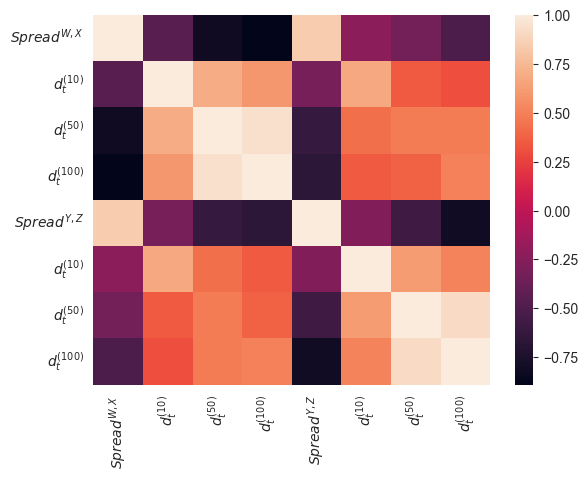

In [48]:
sns.heatmap(pd.concat([df_WX, df_YZ], axis = 1, join = 'inner').corr())
None